In [8]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


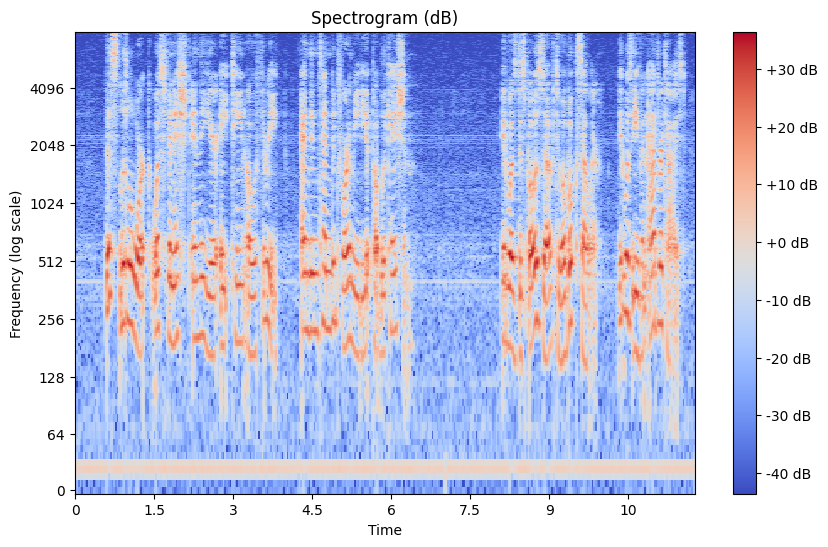

In [3]:
# Here we use an example file from the train-clean-100 subset.
audio_file = "/content/drive/My Drive/git_projects/spring_2025_dl_audio_project_data/LibriSpeech/train-clean-100/19/198/19-198-0001.flac"
# audio_file = "/workspace/jaspar/spring_2025_dl_audio_project_data/LibriSpeech/train-clean-100/19/198/19-198-0001.flac"

# Load the audio file; sr=None preserves the original sampling rate.
y, sr = librosa.load(audio_file, sr=None)

# Create an audio player to listen to the file.
display(Audio(data=y, rate=sr))

# Compute the short-time Fourier transform (STFT).
stft = librosa.stft(y)

# Convert the amplitude spectrogram to decibels for visualization.
stft_db = librosa.amplitude_to_db(abs(stft))

# Plot the spectrogram.
plt.figure(figsize=(10, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency (log scale)')
plt.show()

In [1]:
import torch


def batched_dot_mul_sum(a, b):
    '''Computes batched dot by multiplying and summing'''
    return a.mul(b).sum(-1)


def batched_dot_bmm(a, b):
    '''Computes batched dot by reducing to ``bmm``'''
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    return torch.bmm(a, b).flatten(-3)


# Input for benchmarking
x = torch.randn(10000, 64)

# Ensure that both functions compute the same output
assert batched_dot_mul_sum(x, x).allclose(batched_dot_bmm(x, x))

In [5]:
import timeit

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

mul_sum(x, x):  523.6 us
bmm(x, x):      1014.7 us


In [2]:
import timeit

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

mul_sum(x, x):  700.5 us
bmm(x, x):      1972.3 us


In [5]:
import torch.utils.benchmark as benchmark

t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(t0.timeit(100))
print(t1.timeit(100))

num_threads = torch.get_num_threads()
print(f'Benchmarking on {num_threads} threads')

t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x},
    num_threads=num_threads,
    label='Multithreaded batch dot',
    sub_label='Implemented using mul and sum')

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x},
    num_threads=num_threads,
    label='Multithreaded batch dot',
    sub_label='Implemented using bmm')

print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
setup: from __main__ import batched_dot_mul_sum
  371.00 us
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
setup: from __main__ import batched_dot_bmm
  918.67 us
  1 measurement, 100 runs , 1 thread
Benchmarking on 48 threads
Multithreaded batch dot: Implemented using mul and sum
setup: from __main__ import batched_dot_mul_sum
  1.19 ms
  1 measurement, 100 runs , 48 threads
Multithreaded batch dot: Implemented using bmm
setup: from __main__ import batched_dot_bmm
  1.03 ms
  1 measurement, 100 runs , 48 threads


In [4]:
x = torch.randn(10000, 1024, device='cuda')

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

# Ran each twice to show difference before/after warm-up
print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

AssertionError: Torch not compiled with CUDA enabled

In [6]:
t0 = benchmark.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = benchmark.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

# Run only once since benchmark module does warm-up for us
print(t0.timeit(100))
print(t1.timeit(100))

batched_dot_mul_sum(x, x)
setup: from __main__ import batched_dot_mul_sum
  375.07 us
  1 measurement, 100 runs , 1 thread
batched_dot_bmm(x, x)
setup: from __main__ import batched_dot_bmm
  912.35 us
  1 measurement, 100 runs , 1 thread
